# Optimizing Neural Networks

To remind, necessary ingredients to train NN:
    * model
    * objective
    * optimizer
    
Today we will try to understand basics of optimization of neural networks, giving context for the last two lectures. Goal is to:
* Understand basics of generalization, and the difference between optimization and generalization (more on that in "Understanding generalization" lab)
* Understand impact of hyperparameters in SGD on:

  - generalization (lr, batch size)
  - speed of optimization (lr, momentum, batch size) 

References:
* Deep Learning book chapter on optimization: http://www.deeplearningbook.org/contents/optimization.html

# Setup

In [3]:
# Boilerplate code to get started

%load_ext autoreload
%autoreload 
%matplotlib inline

import json
import matplotlib as mpl
from src import fmnist_utils
from src.fmnist_utils import *

def plot(H):
    plt.title(max(H['test_acc']))
    plt.plot(H['acc'], label="acc")
    plt.plot(H['test_acc'], label="test_acc")
    plt.legend()

mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['figure.figsize'] = (7, 7)
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['axes.labelsize'] = 12

(x_train, y_train), (x_test, y_test) = fmnist_utils.get_data()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


NameError: name 'x_train' is not defined

# Whiteboard exercises

(1 point for each)

* Give a case in which layers in neural networks might learn with different speed. Do layers in neural networks learn with different speeds usually?
* Write expression for RMSProp. Interpret the equation.
* Compare weight decay and L2 regularization. Explain the difference.

# Exercise 1: optimization speed

Assuming fixed number of *epochs*, it is usually better to use either smaller batch size, or larger learning rate. Theoretical reason for it is not completely clear, so let's focus in this exercise on an empirical investigation.

Assume you are allowed to train the given network for 10 epochs. Answer the following questions:

* a) What was the optimal $\eta$ (assuming $S$=128 and $\mu$=0.9) for the final training accuracy?
* b) Did it also provide the best test accuracy? If yes, why (hint: consider if model is under or over-fitting)?
* c) What is the optimal $S$ (assuming $\eta$=0.1 and $\mu$=0.9) for the final training accuracy?
* d) Why is higher learning rate, or smaller batch size, optimizing faster? Give your best explanation (it can be hypothetical, there is no obvious theoretical answer)?

100%|██████████████████████████████████████████| 10/10 [00:01<00:00,  7.87it/s]


0.895


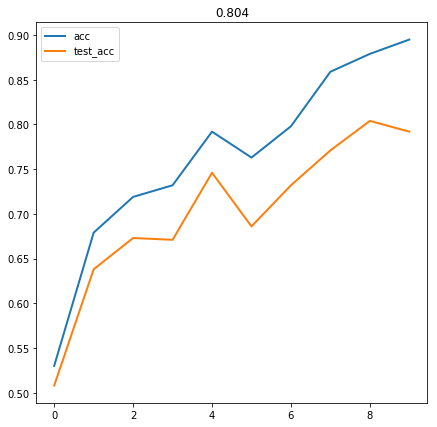

In [17]:
# Some starting code. Loop through different LR and BS and find optimal ones.
model = build_mlp(784, 10, hidden_dims=[512])
loss = torch.nn.CrossEntropyLoss(size_average=True)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
H = train(loss=loss, model=model, x_train=x_train, y_train=y_train,
          x_test=x_test, y_test=y_test,
          optim=optimizer, batch_size=128, n_epochs=10)
plot(H)
print(H["acc"][-1])

In [39]:
answers = {"a": "0.1", "b": "Yes, probably model is over-fitting", "c": "70", "d": "On smaller data (small batch) model tries to be simplier, and hight lr increase steps size in searcing of local extremas"}
json.dump(answers, open("7b_ex1.json", "w"))

# Exercise 2: generalization

Story with generalization is also unclear, but it is generally accepted that higher noise levels in SGD lead to better generalization. Think of noise in optimization (leading to low fidelity, as seen in lab 7a, for instance) as a close analog of typical regularizations (like dropout or batch normalization, that we will discuss next time).

Your task is to:

a) Check a range of LR and BS and find the best generalizing combination of LR and BS. What test accuracy were you able to achieve? What is the best LR and BS combination?

b) Answer the following question: Is stability correlated with using large LR or small BS. If yes, what is the intuitive reason for it? Feel free to give a hypothesis.

Hints:

* Make sure you achieve 100% training accuracy with each run, discard hyperparameters that are not achieving convergence.

Notes:

* Do not change the model in the starting code. It is on purpose a bit more complex MLP.

* You can measure stability by computing margin. This is implemented for you (using DeepFool method, https://arxiv.org/abs/1511.04599). Measuring margin is expensive, so recommended approach would be to compute it only on few final runs. 

In [38]:
answers = {"a": "On less than 120 epochs the best pair of BS and LR was 50,0.07 and 30,0.03", "b": "Yes, cause again small BS allows to train parametres with better precision, that produce larger dispercion, meanwhile lr speed up train process ", "c": "not defined"}
json.dump(answers, open("7b_ex2.json", "w"))

## Stability measure

In 7a lab we discussed bias/variance view. Here, we will take a stability based view. To estimate stability, 
we will record maximum change in prediction when adding gaussian noise to examples. This is a very rudimentary
way to estimate geometric margin of the network, and we will talk more about this later.

In [19]:
from src.deepfool import measure_stability_deepfool

## Finding optimal $\eta$ and $S$

In [37]:
## Starting code

Hs = []
Lrs = [0.01]
batch_sizes = [100]
Margins = []
for batch_size in batch_sizes:
    for lr in Lrs:
        model = build_mlp(784, 10, hidden_dims=[100, 100, 100])
        loss = torch.nn.CrossEntropyLoss(size_average=True)
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
        H = train(loss=loss, model=model, x_train=x_train, y_train=y_train,
                  x_test=x_test, y_test=y_test,
                  optim=optimizer, batch_size=batch_size, n_epochs=400)
        Margins.append(measure_stability_deepfool(model=model, 
                    x_train=x_train, y_train=y_train, loss=loss, N=1000))
        Hs.append(H)
        print("batch_size:", batch_size,"; lr: ", lr, "; accurancy: " ,H["test_acc"][-1], "margins:", Margins)

100%|████████████████████████████████████████| 400/400 [00:19<00:00, 20.86it/s]
C:\Users\Maxim\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Maxim\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


batch_size: 100 ; lr:  0.01 ; accurancy:  0.773 margins: [nan]
